In [1]:
# python
import os
import sys
import importlib
# columnar analysis
from coffea import processor
from coffea.nanoevents import NanoAODSchema
import awkward as ak
from dask.distributed import Client, performance_report
# local
sidm_path = str(os.getcwd()).split("/sidm")[0]
if sidm_path not in sys.path: sys.path.insert(1, sidm_path)
from sidm.tools import utilities, sidm_processor, scaleout, llpnanoaodschema
# always reload local modules to pick up changes during development
importlib.reload(utilities)
importlib.reload(sidm_processor)
importlib.reload(scaleout)
# plotting
import matplotlib.pyplot as plt
utilities.set_plot_style()
%matplotlib inline
from hist import intervals
import coffea.util
# import numpy as np
import mplhep as hep
import numpy as np
import warnings

In [2]:
import yaml
yaml_file_path = '../../configs/ntuples/signal_2mu2e_v10.yaml'
# Open and read the YAML file
with open(yaml_file_path, 'r') as file:
    data = yaml.safe_load(file)
signals_all = list(data["llpNanoAOD_v2"]["samples"].keys())
for x in range(len(signals_all)):
    # if x == 0:
    print("'" + signals_all[x] + "',")
    

'2Mu2E_100GeV_0p25GeV_0p02mm',
'2Mu2E_100GeV_0p25GeV_0p2mm',
'2Mu2E_100GeV_0p25GeV_2p0mm',
'2Mu2E_100GeV_0p25GeV_10p0mm',
'2Mu2E_100GeV_0p25GeV_20p0mm',
'2Mu2E_100GeV_1p2GeV_0p096mm',
'2Mu2E_100GeV_1p2GeV_0p96mm',
'2Mu2E_100GeV_1p2GeV_9p6mm',
'2Mu2E_100GeV_1p2GeV_48p0mm',
'2Mu2E_100GeV_1p2GeV_96p0mm',
'2Mu2E_100GeV_5p0GeV_0p4mm',
'2Mu2E_100GeV_5p0GeV_4p0mm',
'2Mu2E_100GeV_5p0GeV_40p0mm',
'2Mu2E_100GeV_5p0GeV_200mm',
'2Mu2E_100GeV_5p0GeV_400mm',
'2Mu2E_150GeV_0p25GeV_0p013mm',
'2Mu2E_150GeV_0p25GeV_0p13mm',
'2Mu2E_150GeV_0p25GeV_1p3mm',
'2Mu2E_150GeV_0p25GeV_6p7mm',
'2Mu2E_150GeV_0p25GeV_13p0mm',
'2Mu2E_150GeV_1p2GeV_0p064mm',
'2Mu2E_150GeV_1p2GeV_0p64mm',
'2Mu2E_150GeV_1p2GeV_6p4mm',
'2Mu2E_150GeV_1p2GeV_32p0mm',
'2Mu2E_150GeV_1p2GeV_64p0mm',
'2Mu2E_150GeV_5p0GeV_0p27mm',
'2Mu2E_150GeV_5p0GeV_2p7mm',
'2Mu2E_150GeV_5p0GeV_27p0mm',
'2Mu2E_150GeV_5p0GeV_130p0mm',
'2Mu2E_150GeV_5p0GeV_270p0mm',
'2Mu2E_200GeV_0p25GeV_0p01mm',
'2Mu2E_200GeV_0p25GeV_0p1mm',
'2Mu2E_200GeV_0p25GeV_1p0mm',
'2Mu2

In [3]:
QCD=[ 
     "QCD_Pt15To20", 
     "QCD_Pt20To30",
     "QCD_Pt30To50",
     "QCD_Pt50To80",
     "QCD_Pt80To120",
     "QCD_Pt120To170",
    "QCD_Pt170To300",
    "QCD_Pt300To470",
     "QCD_Pt470To600",
     "QCD_Pt600To800",
    "QCD_Pt800To1000",
     "QCD_Pt1000",
    ]
DY = [ 
    "DYJetsToMuMu_M10to50",
    "DYJetsToMuMu_M50",
     ]
TT = [ 
    "TTJets",
     ]

bgs=  TT + QCD + DY


def sum_bgs_hist(bgs_list, histogram_name, channel_name):
    """
    Sum histograms for a list of backgrounds.
    """
    summed_hist = None
    
    for x in bgs_list:
        # print(x)
        output_bg = coffea.util.load(f"output_{x}{channel_name}.coffea")
        hist = output_bg["out"][x]["hists"][histogram_name][channel_name, :]
        
        if summed_hist is None:
            summed_hist = hist.copy()
        else:
            summed_hist += hist
    
    return summed_hist

def plot_signal_and_percentage_grid_all(data):
    # Collect all (bound_mass, zd_mass) pairs
    combos = []
    for mass, zd_dict in data.items():
        for zd in zd_dict.keys():
            combos.append((mass, zd))
    combos = sorted(combos, key=lambda x: (x[0], x[1]))  # sort nicely

    # Collect all Lxy values (y-axis)
    lab_vals = sorted(set(
        lab for mass in data for zd in data[mass] for lab in data[mass][zd].keys()
    ))
    # Initialize grids
    z_yield = np.full((len(lab_vals), len(combos)), np.nan)
    z_percent = np.full((len(lab_vals), len(combos)), np.nan)

    # Fill grids
    for j, (mass, zd) in enumerate(combos):
        for i, lab in enumerate(lab_vals):
            values = data[mass][zd].get(lab, [np.nan, np.nan])
            z_yield[i, j] = values[0]
            z_percent[i, j] = values[1]

    # X-axis labels like "100/0.25"
    x_labels = [f"{m}/{zd}" for m, zd in combos]


    fig, axs = plt.subplots(2, 1, figsize=(48, 30), constrained_layout=True)

    # --- Plot yield ---
    im1 = axs[0].imshow(
        z_yield,
        origin='lower',
        cmap='viridis',
        vmin=0, vmax=5,
        # norm=LogNorm(vmin=1e-2, vmax=1e2),
        aspect='auto'
    )
    axs[0].set_xticks(np.arange(len(combos)))
    axs[0].set_xticklabels(x_labels, rotation=90)
    axs[0].set_yticks(np.arange(len(lab_vals)))
    axs[0].set_yticklabels(lab_vals)
    axs[0].set_title(r"$S/\sqrt{B}$")
    axs[0].set_xlabel(r"Bound state / $m_{Z_d}$ (GeV)")
    axs[0].set_ylabel(r"$L_{xy}$ (cm)")
    plt.colorbar(im1, ax=axs[0])

    # --- Plot percentage ---
    im2 = axs[1].imshow(
        z_percent,
        origin='lower',
        cmap='viridis',
        vmin=0, vmax=0.05,
        aspect='auto'
    )
    axs[1].set_xticks(np.arange(len(combos)))
    axs[1].set_xticklabels(x_labels, rotation=90)
    axs[1].set_yticks(np.arange(len(lab_vals)))
    axs[1].set_yticklabels(lab_vals)
    axs[1].set_title("Threshold")
    axs[1].set_xlabel(r"Bound state / $m_{Z_d}$ (GeV)")
    axs[1].set_ylabel(r"$L_{xy}$ (cm)")
    plt.colorbar(im2, ax=axs[1])

    plt.show()
    plt.close()


In [3]:
ch1 = "base_ljObjCut_pixelHits_as_lj_cut"
ch2 = "base_ljObjCut_pixelHits_as_ljSource"
output_signal_ch1 = coffea.util.load(f"output_signal_{ch1}.coffea" )
output_signal_ch2 = coffea.util.load(f"output_signal_{ch2}.coffea" )
signals_per_plot = 15
n_signals = len(signals_all)
markers = ["o", "s", "^", "D", "v"]
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]
S = [
'2Mu2E_500GeV_0p25GeV_0p004mm',
'2Mu2E_500GeV_0p25GeV_0p04mm',
'2Mu2E_500GeV_0p25GeV_0p4mm',
'2Mu2E_500GeV_0p25GeV_2p0mm',
'2Mu2E_500GeV_0p25GeV_4p0mm',
'2Mu2E_500GeV_1p2GeV_0p019mm',
'2Mu2E_500GeV_1p2GeV_0p19mm',
'2Mu2E_500GeV_1p2GeV_1p9mm',
'2Mu2E_500GeV_1p2GeV_9p6mm',
'2Mu2E_500GeV_1p2GeV_19p0mm',
'2Mu2E_500GeV_5p0GeV_0p08mm',
'2Mu2E_500GeV_5p0GeV_0p8mm',
'2Mu2E_500GeV_5p0GeV_8p0mm',
'2Mu2E_500GeV_5p0GeV_40p0mm',
'2Mu2E_500GeV_5p0GeV_80p0mm',
]


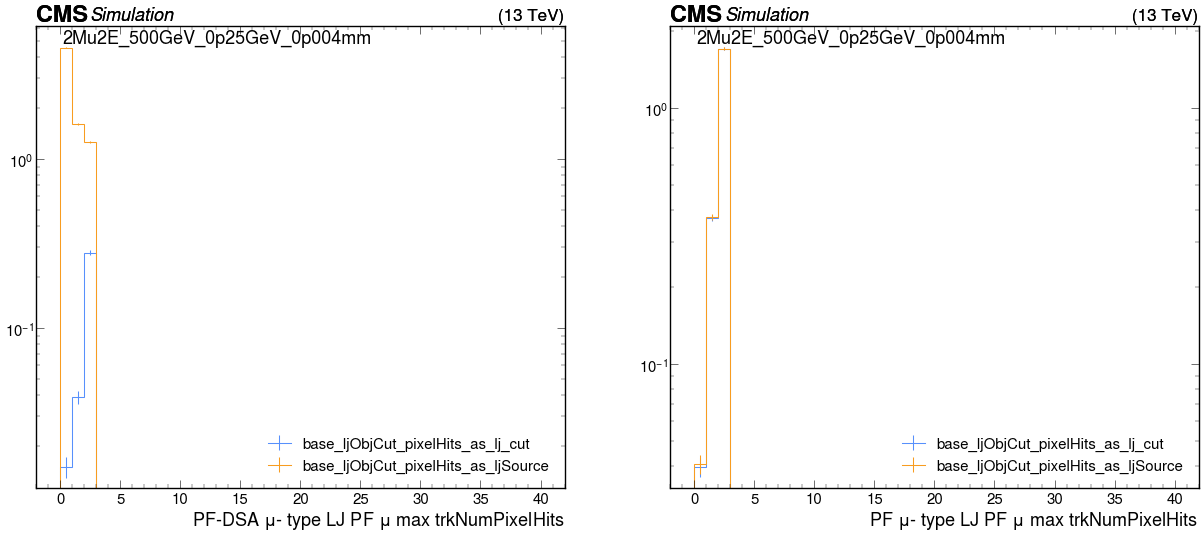

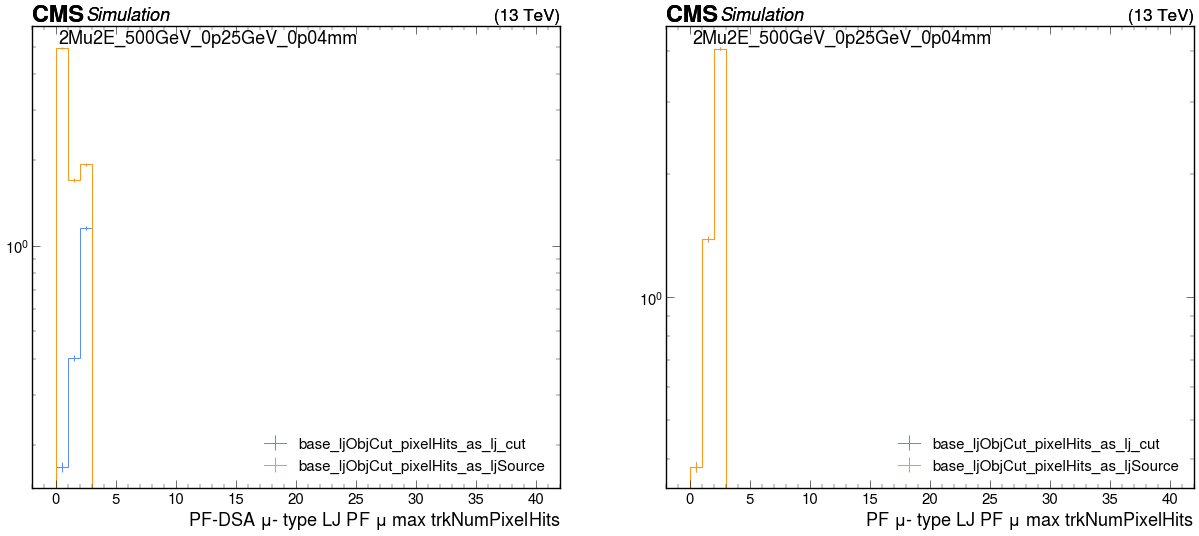

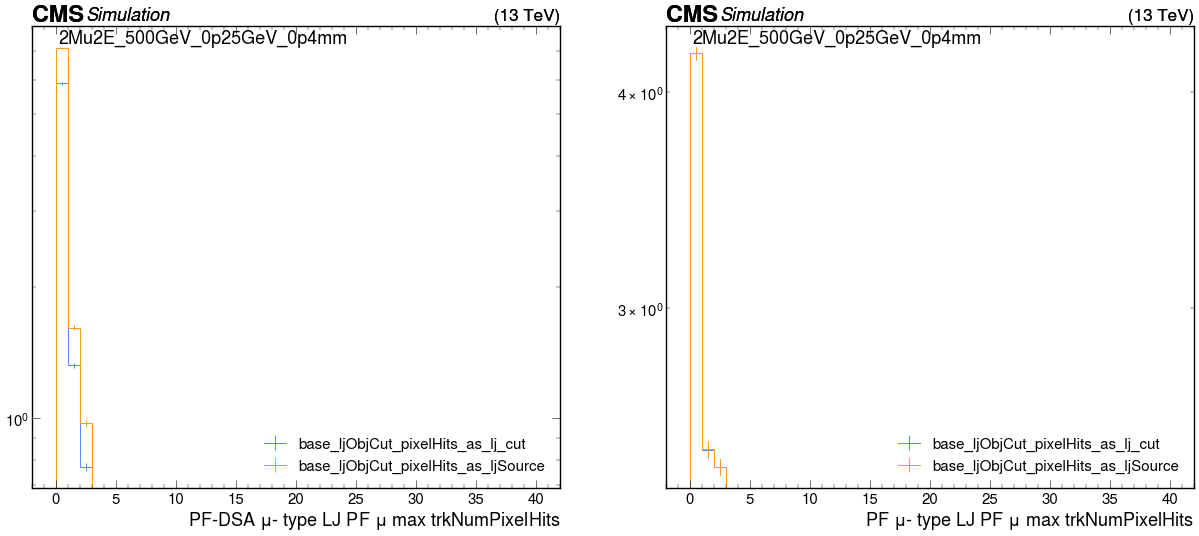

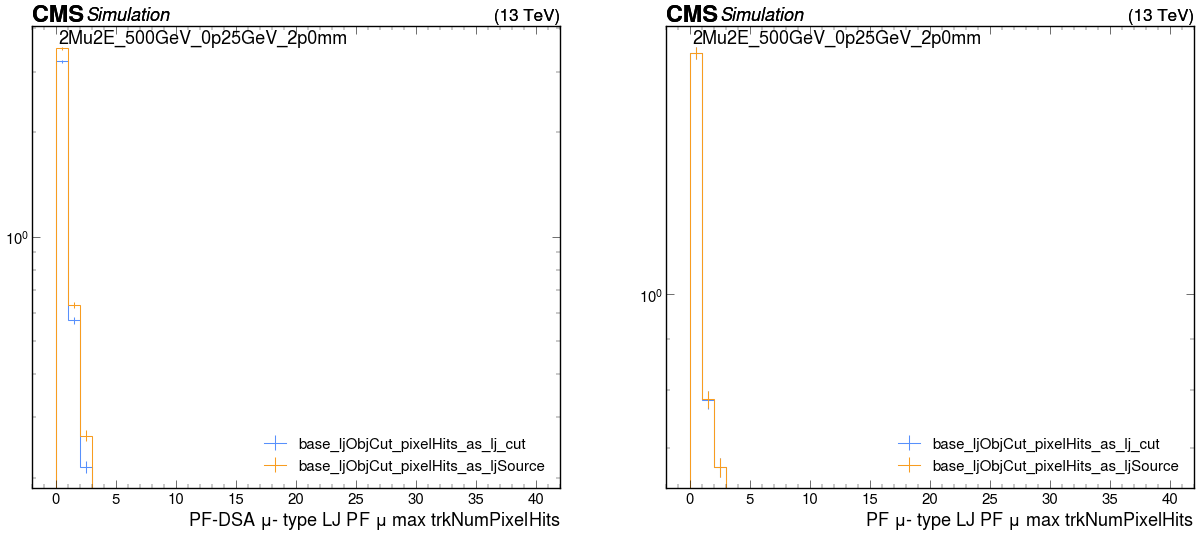

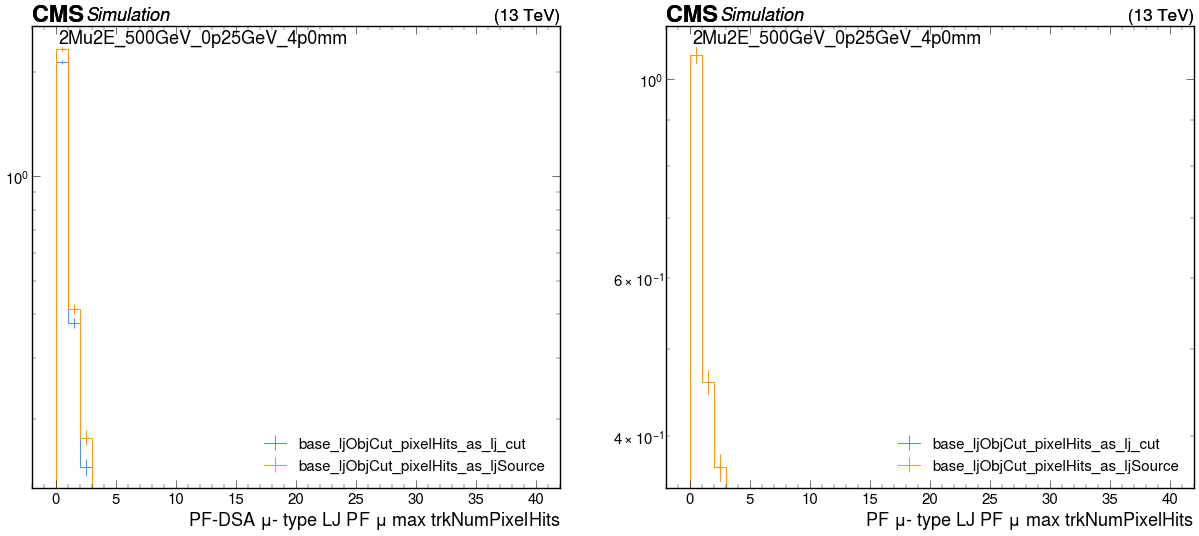

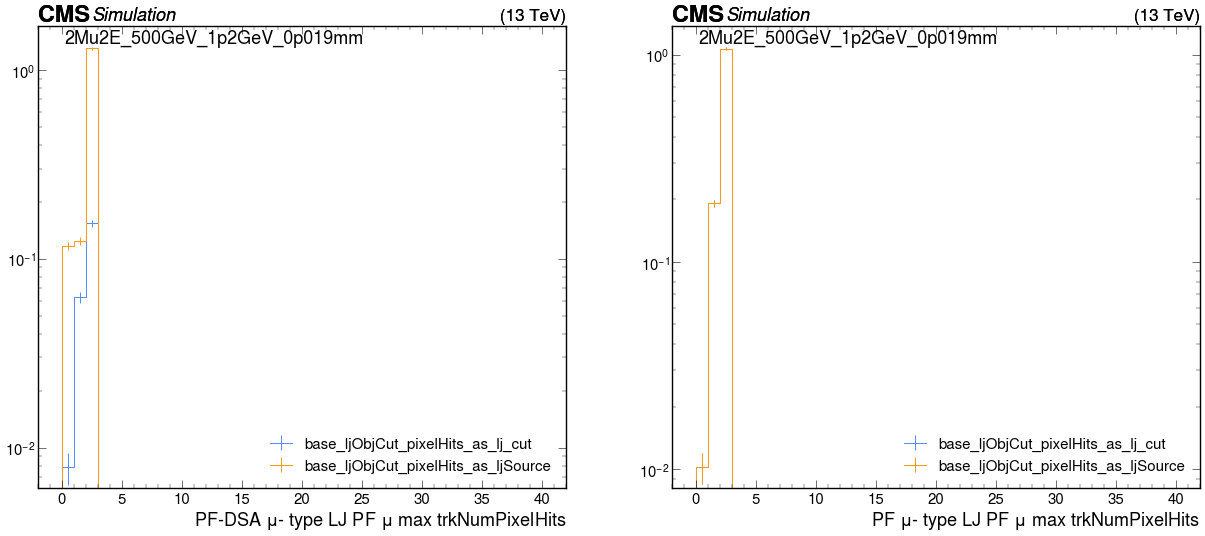

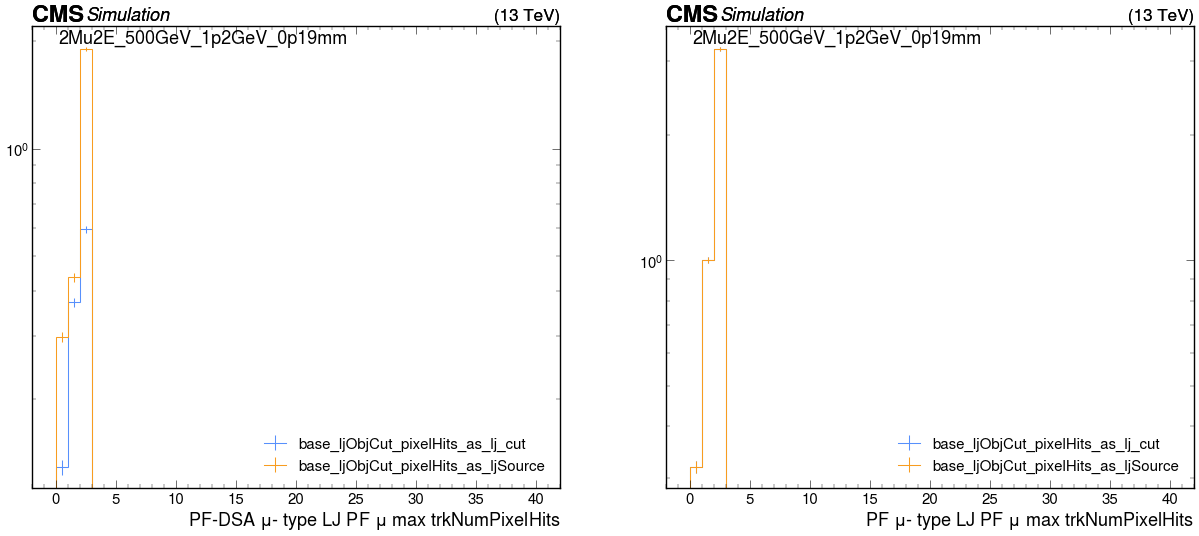

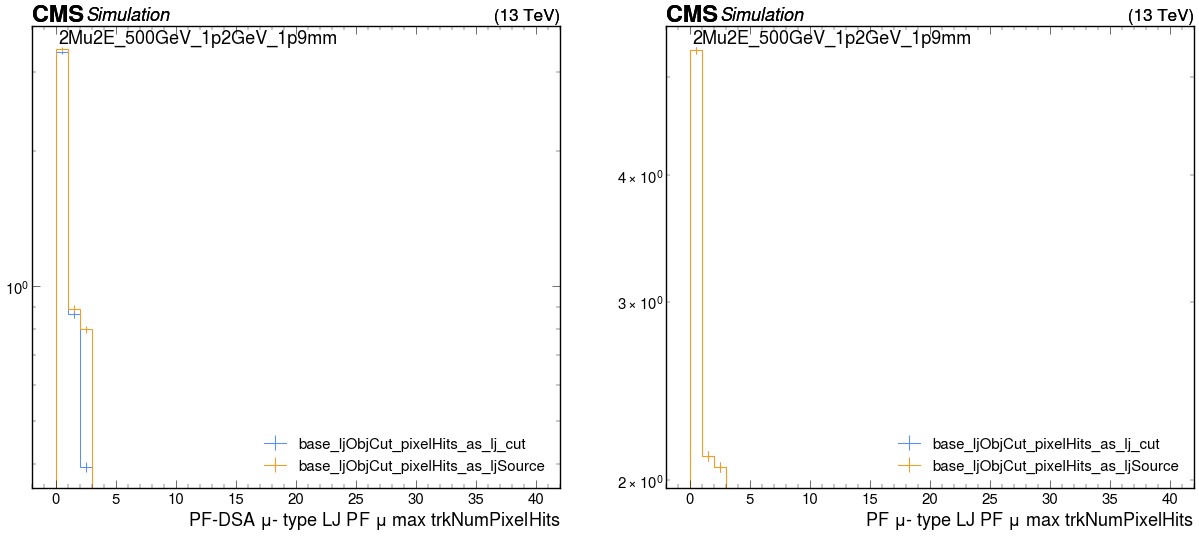

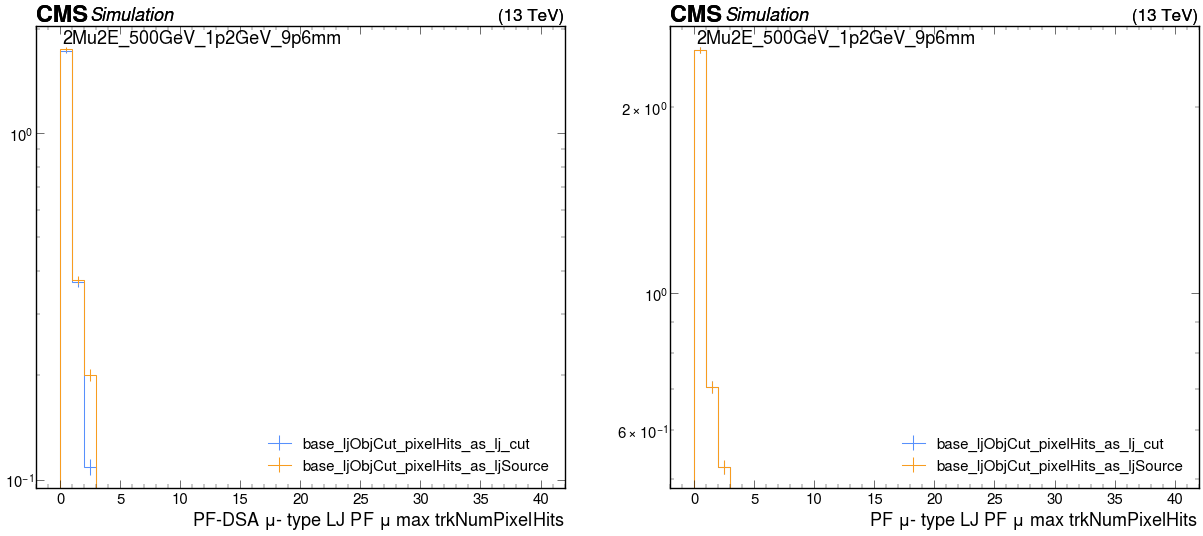

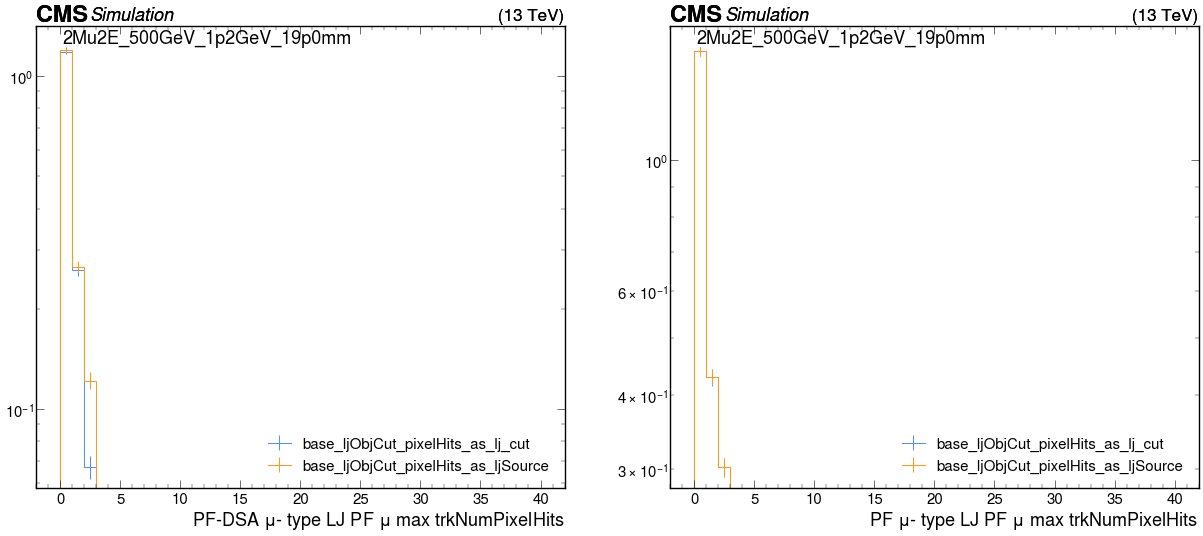

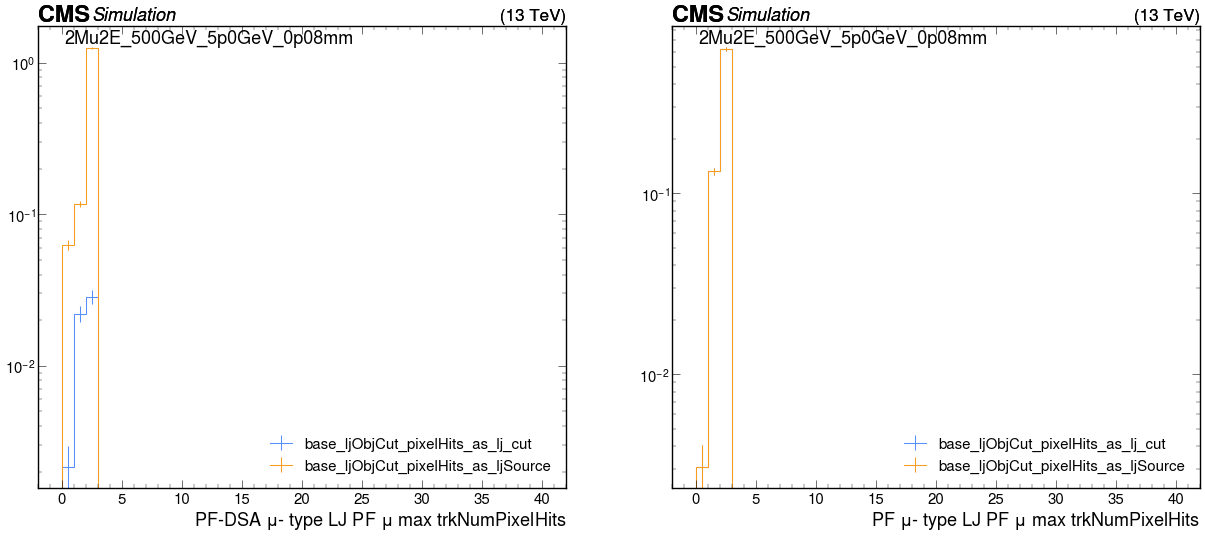

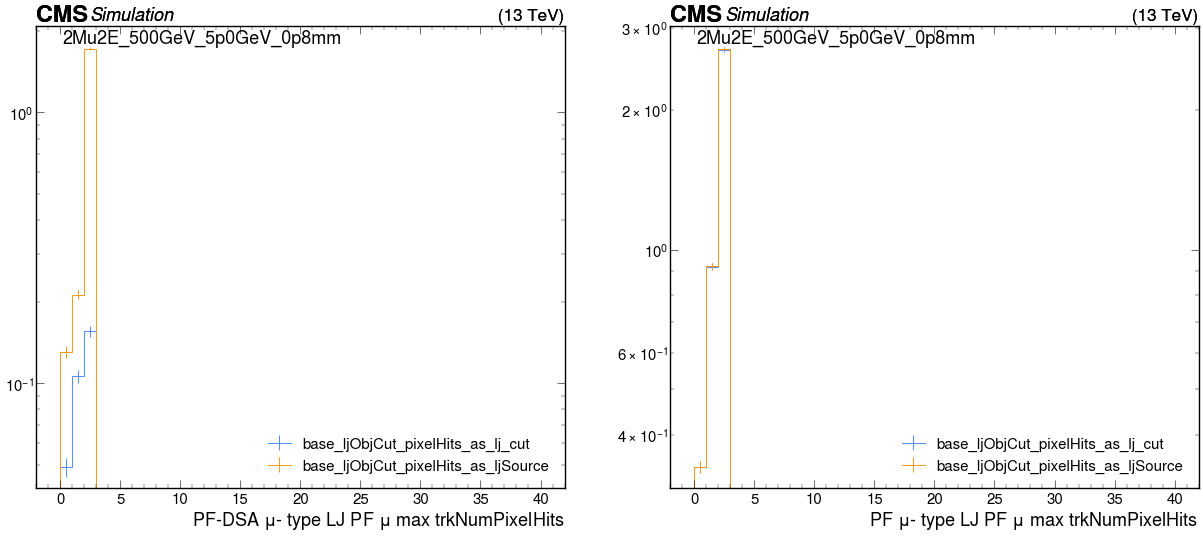

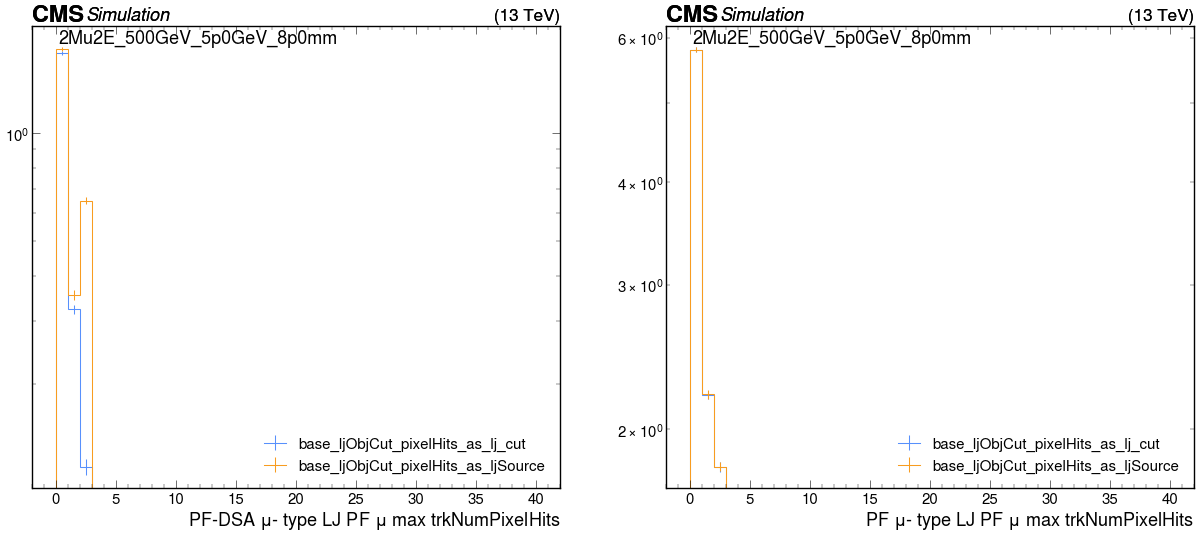

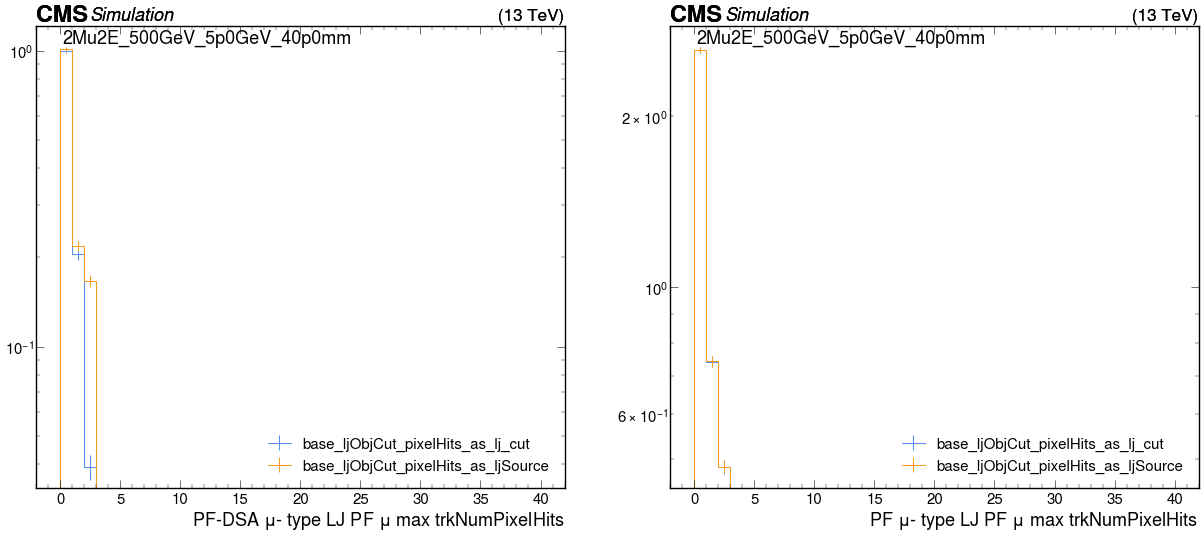

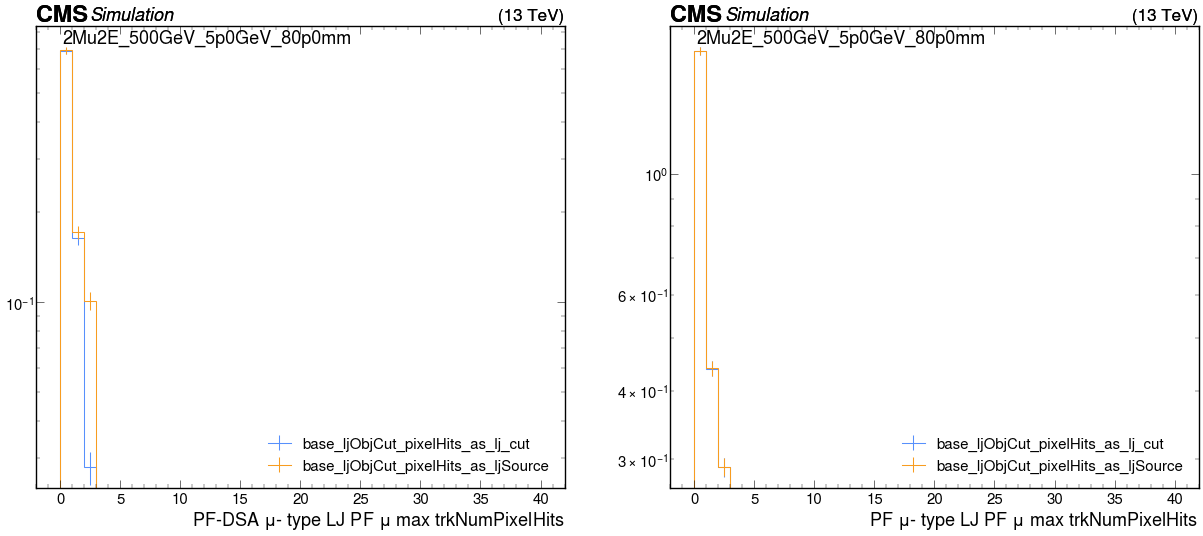

In [16]:

for s in S:
    plt.subplots(1, 2, figsize = (30, 12))
    plt.subplot(1, 2, 1)
    histogram = output_signal_ch1["out"][s]["hists"]["pf_dsa_mu_lj_pfMuon_max_trkNumPixelHits"][ch1, :]
    utilities.plot(histogram, label =ch1)
    histogram = output_signal_ch2["out"][s]["hists"]["pf_dsa_mu_lj_pfMuon_max_trkNumPixelHits"][ch2, :]
    utilities.plot(histogram, label =ch2)
    hep.label.exp_text(text=s, loc=1)  # 0=upper left
    plt.yscale("log")
    plt.legend()
    plt.subplot(1, 2, 2)
    histogram = output_signal_ch1["out"][s]["hists"]["pf_mu_lj_pfMuon_max_trkNumPixelHits"][ch1, :]
    utilities.plot(histogram, label=ch1)
    histogram = output_signal_ch2["out"][s]["hists"]["pf_mu_lj_pfMuon_max_trkNumPixelHits"][ch2, :]
    utilities.plot(histogram, label = ch2)
    hep.label.exp_text(text=s, loc=1)  # 0=upper left
    plt.legend()
    plt.yscale("log")
    plt.show()
    plt.close()
    